<a id=top></a>
# STIS ACQ-FLUX Acquisition <a class="tocSkip">

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-necessary-packages" data-toc-modified-id="Import-necessary-packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import necessary packages</a></span></li></ul></li><li><span><a href="#Define-Function-for-Plotting-Acquisition-Images-and-Performing-Target-Acquisition" data-toc-modified-id="Define-Function-for-Plotting-Acquisition-Images-and-Performing-Target-Acquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Function for Plotting Acquisition Images and Performing Target Acquisition</a></span></li><li><span><a href="#Successful-Target-Acquisition" data-toc-modified-id="Successful-Target-Acquisition-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Successful Target Acquisition</a></span></li><li><span><a href="#Target-Acquisition-Failure-Cases" data-toc-modified-id="Target-Acquisition-Failure-Cases-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Target Acquisition Failure Cases</a></span><ul class="toc-item"><li><span><a href="#Guide-Stars-not-Acquired" data-toc-modified-id="Guide-Stars-not-Acquired-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Guide Stars not Acquired</a></span></li><li><span><a href="#Guide-Star-Acquisition-Delayed" data-toc-modified-id="Guide-Star-Acquisition-Delayed-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Guide Star Acquisition Delayed</a></span></li><li><span><a href="#Lamp-not-illuminated" data-toc-modified-id="Lamp-not-illuminated-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Lamp not illuminated</a></span></li><li><span><a href="#Multiple-Bright-Sources" data-toc-modified-id="Multiple-Bright-Sources-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Multiple Bright Sources</a></span></li><li><span><a href="#Saturation-of-Pixels" data-toc-modified-id="Saturation-of-Pixels-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Saturation of Pixels</a></span></li><li><span><a href="#No-Target-in-the-Acquisition-Image" data-toc-modified-id="No-Target-in-the-Acquisition-Image-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>No Target in the Acquisition Image</a></span></li></ul></li></ul></div>

## Introduction
There are two types of STIS target acquisition: ACQ and ACQ/PEAK. In this notebook, we will go through the steps for ACQ observations, and explore some success and failure cases.


For ACQ observations, the target acquisition data has three science extensions:
- Before Coarse Slew
- Before Fine Slew
- 0.2$\times$0.2 Reference Aperture with HITM lamp

The first science extension (Coarse Phase) of the acquisition raw file is an image of target in the target acquisition sub-array based on initial pointing. Then the coarse centering is performed: the software determines the position of the target with a flux weighted poiting algorithm, and calculates the slew needed to place the target at a reference point in the target acquisition sub-array; the coarse centered image is stored in the second science extension (Fine Phase). The next step is to perform fine centering: a 32 $\times$ 32 pixel image of the reference aperture is obtained and stored in the third science extension (Reference Aperture), the location of the aperture on the detector is determined, and a fine slew is performed to center the taret in the reference aperture (to place the object precisely in a slit).

For more information on ACQ target acquisition, see [`Evaluating Target Acquisitions and Guiding`](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-2-evaluating-target-acquisitions-and-guiding).

### Import necessary packages

**We will import the following packages:**

- `astropy.io fits` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `pathlib`,`os` for managing system paths
- `matplotlib` for plotting data
- `stistools` for quick operations on STIS Data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
from pathlib import Path
import os

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from astropy.visualization import ZScaleInterval
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'viridis'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['figure.figsize'] = (20,7)

# Import for operations on STIS Data
import stistools

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


## Define Function for Plotting Acquisition Images and Performing Target Acquisition

We define a function to plot the three science image extensions mentioned above, and run the stistools_tastis target acquisition method to show the result and associated information of target acquisition.

In [2]:
def acq(obs_id):
    # Search target objscy by obs_id
    target = Observations.query_criteria(obs_id=obs_id)
    # get a list of files assiciated with that target
    acq_list = Observations.get_product_list(target)
    # Download only the _raw and _spt fits files
    Observations.download_products(acq_list,extension=['raw.fits','spt.fits'])
    raw = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_raw.fits".format(obs_id))
    
    # plot the acquisition raw images
    with fits.open(raw) as hdu:
        initial = hdu[1].data
        confirm = hdu[4].data
        lamp = hdu[7].data
    zscaler = ZScaleInterval(contrast=0.10).get_limits 
    _, initial_max = zscaler(initial)
    _, confirm_max = zscaler(confirm)
    vmax = max(initial_max,confirm_max)
    
    # plot the initial target position in coarse phase
    TARGA1_1 = fits.getheader(raw,1)["TARGA1"]
    TARGA2_1 = fits.getheader(raw,1)["TARGA2"]
    TARGA1_2 = fits.getheader(raw,4)["TARGA1"]
    TARGA2_2 = fits.getheader(raw,4)["TARGA2"]
    centera1 = fits.getheader(raw,0)["CENTERA1"]
    centera2 = fits.getheader(raw,0)["CENTERA2"]
    sizaxis1 = fits.getheader(raw,0)["sizaxis1"]
    sizaxis2 = fits.getheader(raw,0)["sizaxis2"]
    corner1 = centera1 - sizaxis1/2 
    corner2 = centera2 - sizaxis2/2
    
    checkbox_size = fits.getheader(raw,0)["CHECKBOX"]
    
    
    plt.subplot(1,3,1)
    plt.imshow(initial,vmin = 0,vmax = vmax)
    plt.plot([TARGA1_1-corner1+1],[TARGA2_1-corner2+1],"rx")
    plt.title("Before Coarse Slew")
    plt.subplot(1,3,2)
    plt.imshow(confirm,vmin = 0,vmax = vmax)
    plt.plot([TARGA1_2-corner1+1],[TARGA2_2-corner2+1],"rx")
    plt.title("Before Fine Slew")
    plt.subplot(1,3,3)
    plt.imshow(lamp,vmin = 0,vmax = vmax)
    plt.title(r"$0.2 \times 0.2 Reference Aperture with HITM lamp$")
    plt.tight_layout()
    
    stistools.tastis.tastis(raw)

## Successful Target Acquisition
Here we present a successful target acquisition case in which the target is correctly selected from the initial pointing image, coarse centering and fine centering are successfully performed, and the target is eventually centered in the slit. The target location, coarse slew, and fine slew data are printed by stistools.tastis. Note here that the coordinate system of tastis is 1-indexed while Python is 0-indexed.

octka2daq       HST/STIS    MIRVIS      F25ND3             ACQ/POINT
prop: 14161      visit: A2    line: 1   target: HD-84937
obs date, time: 2016-04-30    10:09:43   exposure time:  2.10
dom GS/FGS: N6U6000023F2    sub-dom GS/FGS: N6U7000178F1
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 3194

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    531.9  516.2    45.9  51.2

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -3.8   0.2    -0.196  0.010       -0.131 -0.145
-------------------------------------------------------------------------------
Fine locate phase:            Target flux

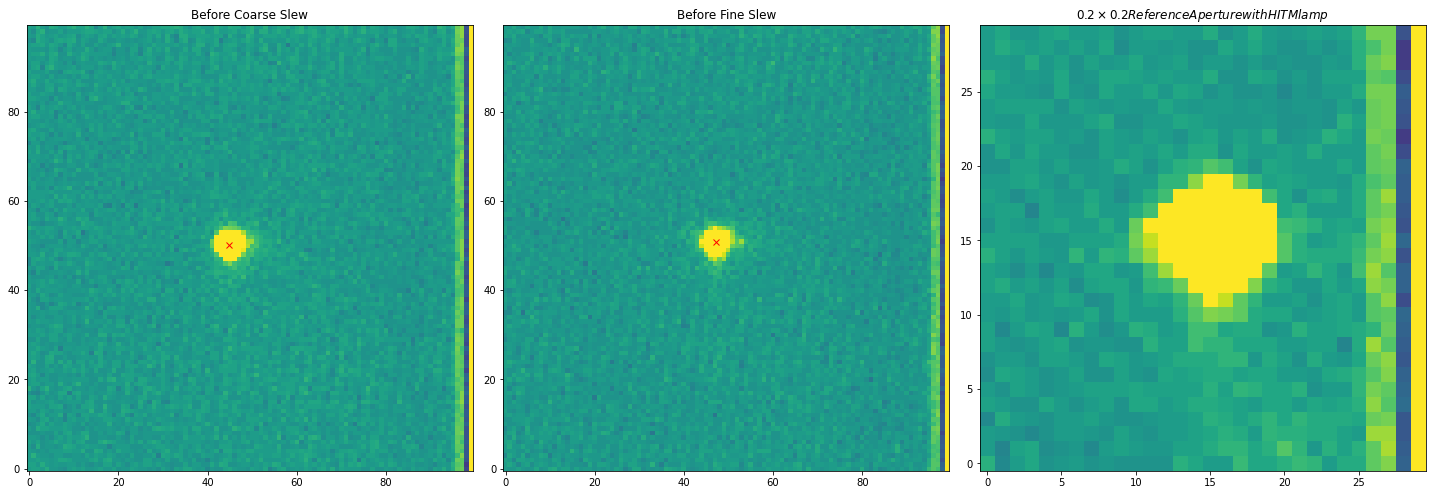

In [3]:
acq("octka2daq")

## Target Acquisition Failure Cases
The tastis analyzes STIS target acquisitions, and prints warning information if the acquisition fails. The possible tastis failures are: 
 - Telemetry indicates that the intended exposures may not have been performed.  Check the images for signal.
 - The fine slew (to center the target in the reference aperture) is larger than 4 pixels.  This may indicate a problem with your acquisition.
 - The fluxes in the maximum checkbox in the fine and coarse stages differ by more than 25%.  This may indicate a problem with your acquisition.
 - The flux in the third image of the ACQ is lower than the typical value for the lamp; the image should be checked to see if the lamp was illuminated.
 - Saturation of pixels in the second image may have affected the final centering.
 
Sometimes a failure case might be caused by multiple acquisition warnings. In this section, we will go through several typical cases of acquisition failure. 

### Guide Stars not Acquired
The TakeData Flag is an onboard pointing control system flag which, when ON, indicates that the spacecraft is ready for an observation and that the guide star tracking performance is nomial. If the TDF is down, exposures are not performed until TDF comes up.

If the guide stars are not acquired during acquisition, the TDF will be turned down and no exposures will be performed. Therefore all acquisition images will be dark.

In this failure case, as telemetry indicates, the TDF is down at the start and no exposure was performed. Thus there is not a clear bright source in the Before Coarse Slew and Before Fine Slew images. Usually,exposure failures can also cause other issues such as fine slew larger than 4 pixels or Ratio of Flux in Max Checkbox in Fine & Coarse Stages Greater than 25%, because the tastis algorithm cannot pick up the proper bright source in the image to perform the following steps of acquisition.

oeds03rzq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 16218      visit: 03    line: 1   target: 47TUC-OFFSET1
obs date, time: 2022-02-24    05:53:24   exposure time:  2.27
dom GS/FGS: S0W5000538F2    sub-dom GS/FGS: S0WC000284F1
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 106

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    533.0  564.0    47.0  99.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -2.7  48.0    -0.139  2.438        1.626 -1.822
-------------------------------------------------------------------------------
Fine locate phase:            Target

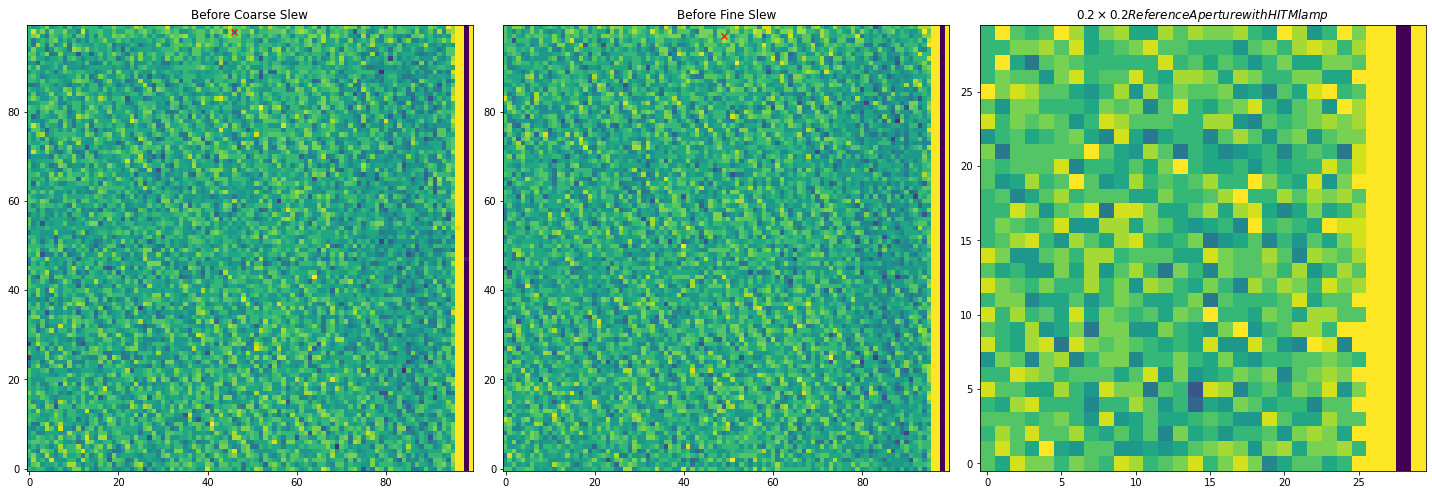

In [4]:
acq("oeds03rzq")

### Guide Star Acquisition Delayed
In this failure case, the guide star acquisition is delayed during the coarse phase, but the guide stars are then acquired in the fine phase. Therefore the first acquisition image is dark while the target is in the second acquisition image. Eventually the target will still be centered, but the large fine slews may result in less precise positioning.

oe1l55vjq       HST/STIS    MIRVIS      F25ND5             ACQ/POINT
prop: 15905      visit: 55    line: 1   target: FOMALHAUT2
obs date, time: 2021-08-20    08:11:54   exposure time:  2.87
dom GS/FGS: SBKK000020F3    sub-dom GS/FGS: SBLC000216F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 106

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    541.0  516.9    55.0  51.9

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:      5.3   0.9     0.267  0.046        0.221  0.156
-------------------------------------------------------------------------------
Fine locate phase:            Target flu

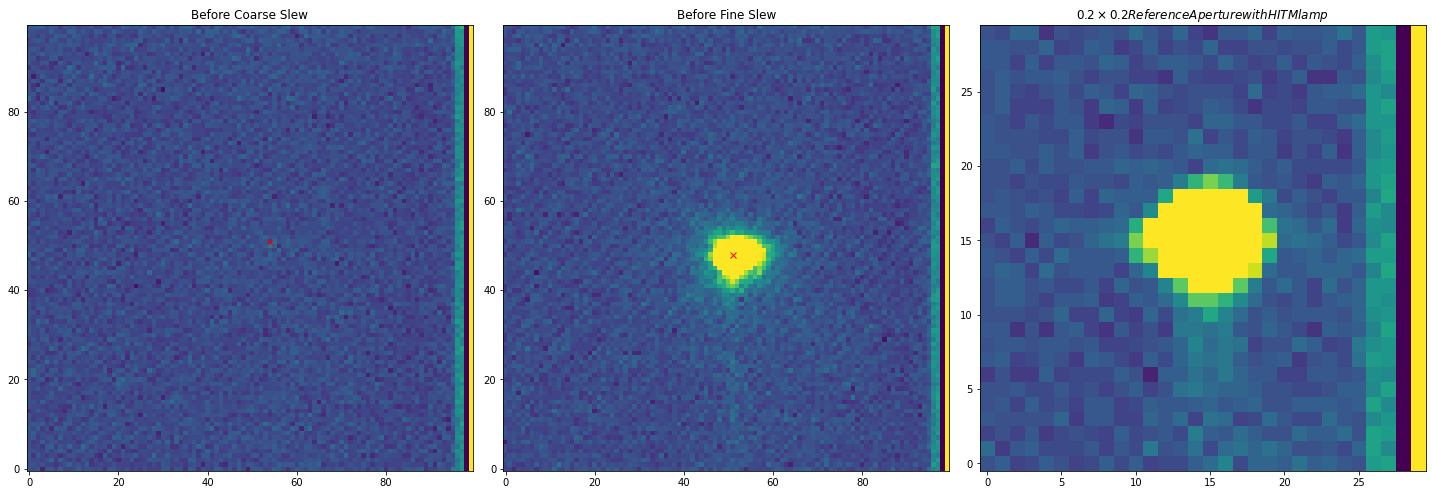

In [5]:
acq("oe1l55vjq")

### Lamp not illuminated
As shown in the reference aperture, the reference aperture HITM lamp is dark and it has a flux smaller than the typical minumun value for the lamp. Usually, this kind of failure occurs if the TDF is down when the lamp image is taken; however, in some rare cases, the lamp might not be functioning. If the lamp image is blank, the target might not be centered in the reference aperture.

oec62hj6q       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 16230      visit: 2H    line: 1   target: LMC-X-4
obs date, time: 2021-04-11    23:09:27   exposure time:  4.77
dom GS/FGS: S13H000373F1    sub-dom GS/FGS: S13H000845F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 3788

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    534.7  515.0    48.7  50.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -1.0  -1.0    -0.052 -0.051       -0.073 -0.001
-------------------------------------------------------------------------------
Fine locate phase:            Target flux

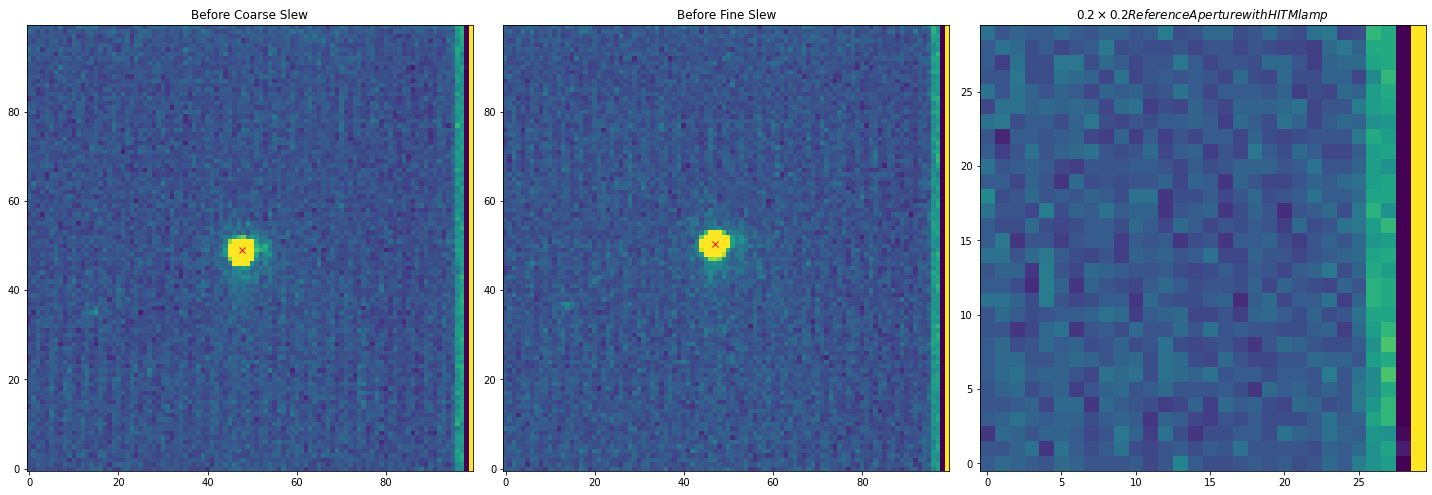

In [6]:
acq("oec62hj6q")

### Multiple Bright Sources
If there are multiple bright sources in a single acquisition image, the maximum checkbox will go through the image and find the brightest one. However, the brightest source might not be the target for this acquisition.

oec159a1q       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 16272      visit: 59    line: 1   target: RMC-140
obs date, time: 2022-01-31    01:06:09   exposure time:  0.50
dom GS/FGS: S1HE000172F1    sub-dom GS/FGS: S1HE000360F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 3414

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    534.8  515.0    48.8  50.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -0.9  -1.0    -0.047 -0.051       -0.069  0.003
-------------------------------------------------------------------------------
Fine locate phase:            Target flux

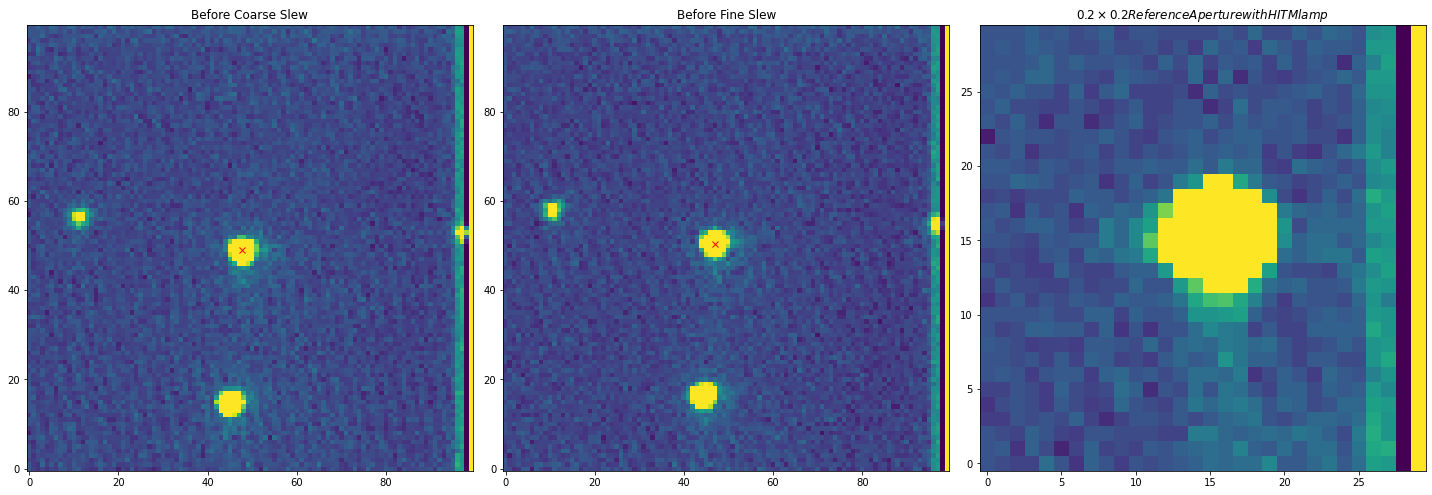

In [7]:
acq("oec159a1q")

### Saturation of Pixels
For the CCD detector, if a pixel is saturated, the excess charge will leak to adjacent pixels in the column. Saturations of pixels will affact the target flux in the max checkbox and the final centering.

oe4h03rdq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 15836      visit: 03    line: 1   target: V-AU-MIC-1
obs date, time: 2020-07-03    00:20:25   exposure time:  0.50
dom GS/FGS: SCLW000169F1    sub-dom GS/FGS: SCLW000085F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 233847

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    534.8  513.0    48.8  48.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -0.9  -3.0    -0.047 -0.152       -0.141  0.074
-------------------------------------------------------------------------------
Fine locate phase:            Target

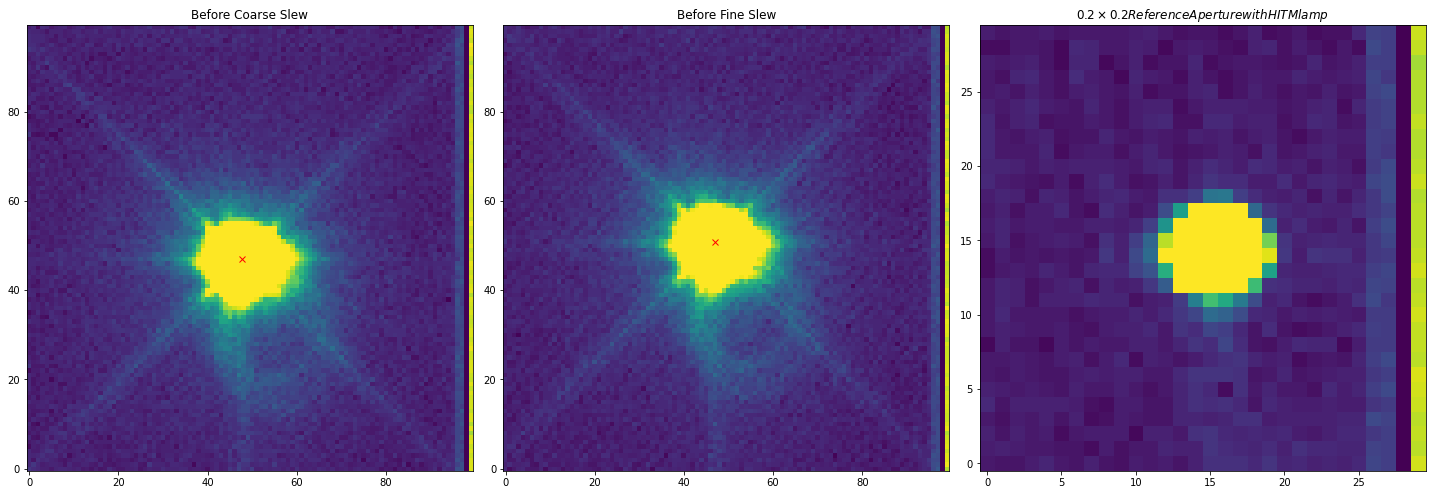

In [8]:
acq("oe4h03rdq")

If we zoom in to the center of the second acquisition image and change the color scale, we can see that the pixels in the center are saturated, and the excess charges follow downward along the column so that the pixels below are affected.

(35.0, 65.0)

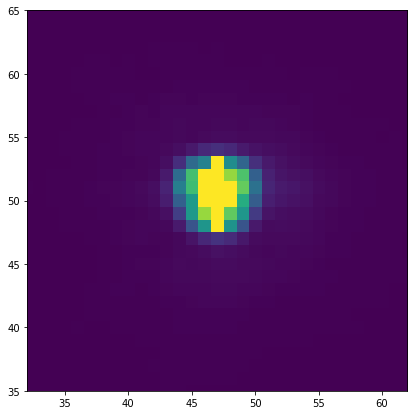

In [9]:
raw = os.path.join("./mastDownload/HST","{}".format("oe4h03rdq"),"{}_raw.fits".format("oe4h03rdq"))
with fits.open(raw) as hdu:
    confirm = hdu[4].data
plt.imshow(confirm,vmin = 0,vmax = 1e4)
plt.xlim(32,62)
plt.ylim(35,65)

### No Target in the Acquisition Image
In this failure case, the guide stars were acquired successfully, and the TDF is always on through the exposure. However, the first and second acquisition images are blank and no target is acquired. This kind of failure happens if the submitted target location/orientation is wrong, or the source is too faint to be observed.

ocyg39yoq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 14257      visit: 39    line: 1   target: C2013X1
obs date, time: 2016-06-10    12:33:13   exposure time:  2.10
dom GS/FGS: SCJV000223F1    sub-dom GS/FGS: NONE
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 295

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    537.0  549.0    51.0  84.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:      1.3  33.0     0.065  1.676        1.231 -1.140
-------------------------------------------------------------------------------
Fine locate phase:            Target flux in max c

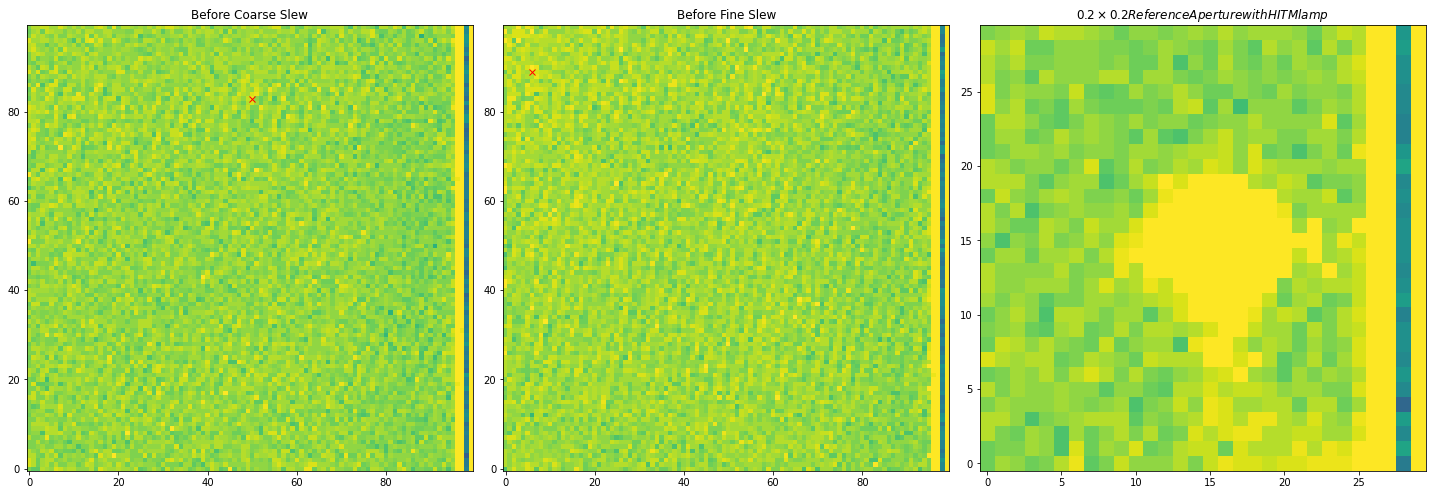

In [10]:
acq("ocyg39yoq")


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2022-11-08


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 